# INIT

In [ ]:
!pip install "dask[complete]"
!pip install pyarrow pandas

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 18.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import dask.dataframe as dd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import mse
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, LayerNormalization, BatchNormalization
from sklearn.metrics import recall_score, precision_score,accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Lambda, Layer

#1. Data Preparation for Rule 15

In [ ]:
#1. Reading and Converting the Data
df_individual = dd.read_parquet('/content/drive/MyDrive/df_individual_df_40d.parquet')
df_individual_df = df_individual.compute()


In [ ]:
df_individual_df

,CUST_CUSTNO,AMOUNT,VALUEDATE
index,,,
0,a168d638771f6240e978956399d9f16621b02655b20ae8...,-9600.00,20230801
1,4fd201b58b6b81ad3366160ff82f3d53f622e0290a57db...,-100.00,20230801
2,52dcdc6af49899ae1dfae36d4eee1625fe717ac6897c2b...,-99.20,20230801
3,db34f14574441e3f42d7ea1d5299204ea481f9ac8f5ff5...,-120.00,20230801
4,49454b2d0968a2714066486a540ac8f0a57ee432cc3ca4...,-120.00,20230801
...,...,...,...
623550,b7a87502f6fc0186f4121a76a9780cb36b693e1582b8ab...,100000.00,20230909
623551,6e9f203c3dc24face6bff660ee9b32b7ea16d0efb9dfe1...,70267.53,20230909
623552,64b35de667d8ce5291f80e98f3da63931855d251eb8cb2...,52394.52,20230909


In [ ]:
# Date Conversion:
df_individual_df['VALUEDATE'] = pd.to_datetime(df_individual_df['VALUEDATE'], errors='coerce')
df_individual_df['DATE_ONLY'] = df_individual_df['VALUEDATE'].dt.date


In [ ]:
#Separate Deposits and Withdrawals
chunk_size = 100000
num_rows = df_individual_df.shape[0]

df_deposits_list = []
df_withdrawals_list = []

for start in range(0, num_rows, chunk_size):
    chunk = df_individual_df[start:start + chunk_size]
    chunk['AMOUNT'] = chunk['AMOUNT'].fillna(0)
    df_deposits_list.append(chunk[chunk['AMOUNT'] > 0])
    df_withdrawals_list.append(chunk[chunk['AMOUNT'] < 0])

df_deposits = pd.concat(df_deposits_list, ignore_index=True)
df_withdrawals = pd.concat(df_withdrawals_list, ignore_index=True)


In [ ]:

#Aggregate by Customer and Date
daily_deposits = df_deposits.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_deposits')
daily_withdrawals = df_withdrawals.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_withdrawals')


In [ ]:
#Merging and Filling Missing Values
transactions = pd.merge(daily_deposits, daily_withdrawals, on=['CUST_CUSTNO', 'DATE_ONLY'], how='outer')
transactions['total_deposits'].fillna(0, inplace=True)
transactions['total_withdrawals'].fillna(0, inplace=True)


In [ ]:
# Log Transform the Data
transactions['log_total_deposits'] = np.log1p(transactions['total_deposits'])
transactions['log_total_withdrawals'] = np.log1p(transactions['total_withdrawals'].abs())


# 2. Data Preprocessing with Kmeans

In [ ]:
# Applying K-means clustering
features = transactions[['log_total_deposits', 'log_total_withdrawals']].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Elbow method
wcss = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)


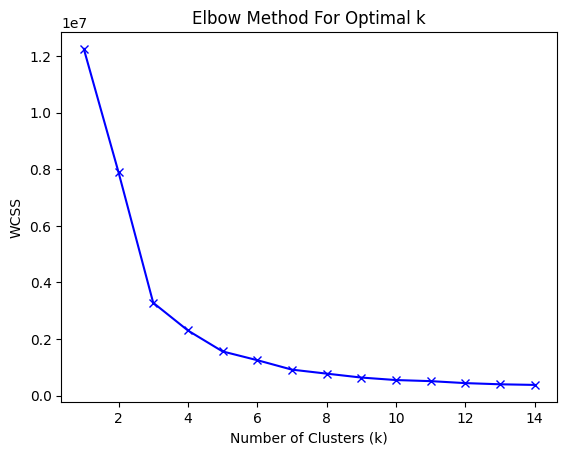

In [ ]:
plt.plot(K_range, wcss, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()


In [ ]:
print(f"Original input dimension: {features_scaled.shape}")

Original input dimension: (6128277, 2)


In [ ]:
#K-Means Clustering with Chosen K
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)
transactions['kmeans_label'] = kmeans_labels


In [ ]:
# Rule-based anomalies
rule_15_anomalies = transactions[
    (transactions['total_deposits'] >= 6000000) &
    (transactions['total_withdrawals'].abs() >= 0.95 * transactions['total_deposits'])
]
rule_15_anomalies

,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,kmeans_label
823,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-22,10469355.99,-10051700.46,16.163963,16.123252,0
830,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-29,7179280.10,-7513252.10,15.786710,15.832179,0
5825,003e0235aab29e1788ce064113f24f8703921030065318...,2023-08-07,11236003.08,-12497903.80,16.234634,16.341072,0
7971,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-03,7162326.10,-7162163.01,15.784346,15.784323,0
7973,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-07,6172231.88,-6342641.09,15.635571,15.662806,0
...,...,...,...,...,...,...,...
6119878,ffa1f3b742233373eedaf14f21c5c2833beed4b44eb6f3...,2023-08-29,27950000.05,-40949450.00,17.145928,17.527849,0
6120684,ffabda738508e4c6a75e696549413207707ac1366d57a8...,2023-08-11,6474800.00,-6316800.00,15.683428,15.658723,0
6126278,ffecb0aaab47e4d92ac4176cdee0c3d9dd4617216035c8...,2023-08-31,6242683.78,-6231263.79,15.646921,15.645090,0
6127083,fff5865d6fd5d7a5893f904b1cb18479fa79ea3b09c4b3...,2023-08-07,9435971.82,-9437298.90,16.060040,16.060180,0


In [ ]:

# Analyzing and Displaying Clusters
cluster_summary = transactions.groupby('kmeans_label').agg({
    'total_deposits': ['mean', 'std', 'min', 'max'],
    'total_withdrawals': ['mean', 'std', 'min', 'max']
})
cluster_summary

total_deposits                                   \
                       mean           std   min          max   
kmeans_label                                                   
0             160590.355891  2.621237e+06  7.13  954992660.0   
1              11195.837696  3.043670e+05  0.00  240000000.0   
2                 11.452331  3.591341e+01  0.00        270.0   

             total_withdrawals                                    
                          mean           std           min   max  
kmeans_label                                                      
0               -160787.436663  2.701862e+06 -8.917823e+08 -10.0  
1                    -3.294915  1.441045e+01 -1.370000e+02   0.0  
2                 -6842.227379  3.750896e+05 -2.833379e+08  -2.7

In [ ]:
total_samples = len(transactions)
cluster_counts = transactions['kmeans_label'].value_counts()
print("Cluster Counts and Percentage of Samples:")
for cluster_label, count in cluster_counts.items():
  percentage = (count / total_samples) * 100
  print(f"Cluster {cluster_label}: Count = {count}, Percentage = {percentage:.2f}%")


Cluster Counts and Percentage of Samples:
Cluster 2: Count = 2386093, Percentage = 38.94%
Cluster 0: Count = 2183661, Percentage = 35.63%
Cluster 1: Count = 1558523, Percentage = 25.43%


In [ ]:
#Selecting the Cluster Containing Anomalies
cluster_0_data = features_scaled[transactions['kmeans_label'] == 0]



In [ ]:
cluster_0_data.shape

(2183661, 2)

#3. VAE + Transformer Deep Learning Approach


**VAE Model**

Epoch 1/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.6219 - val_loss: 0.3232
Epoch 2/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.3225 - val_loss: 0.3225
Epoch 3/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3216 - val_loss: 0.3221
Epoch 4/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3206 - val_loss: 0.3215
Epoch 5/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3205 - val_loss: 0.3212
Epoch 6/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3200 - val_loss: 0.3199
Epoch 7/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3204 - val_loss: 0.3206
Epoch 8/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3203 - val_loss: 0.3201
Epoch 9/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3198 - val_loss: 0.3202
Epoch 10/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3194 - val_loss: 0.3220
Epoch 11/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3199 - val_loss: 0.3203
Epoch 12

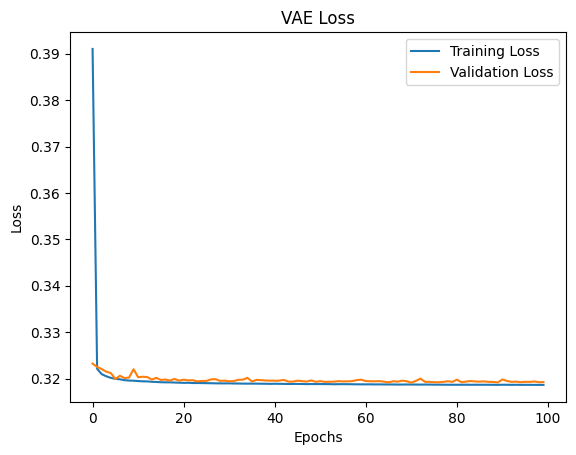

In [ ]:
# Set hyperparameters based on the input shape
latent_dim = 2  # Reduced due to the small input dimension
batch_size = 256  # Adjusted for memory efficiency
epochs = 100  # Number of epochs, can be adjusted based on convergence

# Build the Encoder model
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    h= layers.Dense(128, activation='relu')(inputs)
    h = BatchNormalization()(h)  # Add Batch Normalization
    h = layers.Dense(64, activation='relu')(h)
    h = BatchNormalization()(h)  # Add Batch Normalization
    z_mean = layers.Dense(latent_dim)(h)
    z_log_var = layers.Dense(latent_dim)(h)
    return Model(inputs, [z_mean, z_log_var])

# Build the Decoder model
def build_decoder(output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    h = layers.Dense(64, activation='relu')(latent_inputs)
    h = BatchNormalization()(h)  # Add Batch Normalization
    h = layers.Dense(128, activation='relu')(h)
    h = BatchNormalization()(h)  # Add Batch Normalization
    outputs = layers.Dense(output_dim)(h)
    return Model(latent_inputs, outputs)

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE Loss Layer
class VAELoss(layers.Layer):
    def call(self, inputs):
        x, reconstructed, z_mean, z_log_var = inputs
        reconstruction_loss = tf.reduce_mean(tf.square(x - reconstructed), axis=-1)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return reconstructed

# Build the VAE model
def build_vae(encoder, decoder):
    inputs = layers.Input(shape=(cluster_0_data.shape[1],))
    z_mean, z_log_var = encoder(inputs)
    z = Sampling()([z_mean, z_log_var])
    reconstructed = decoder(z)
    outputs = VAELoss()([inputs, reconstructed, z_mean, z_log_var])
    return Model(inputs, outputs)

# Create and compile the VAE
encoder = build_encoder(cluster_0_data.shape[1])
decoder = build_decoder(cluster_0_data.shape[1])
vae = build_vae(encoder, decoder)

vae.compile(optimizer=Adam(learning_rate=1e-4))

# Train the VAE
history = vae.fit(cluster_0_data, cluster_0_data, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VAE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Step 1: Extract the latent space representation from the VAE
z_mean, z_log_var = encoder.predict(cluster_0_data)  # Assuming encoder is already defined and trained

68240/68240 ━━━━━━━━━━━━━━━━━━━━ 79s 1ms/step


**Transformer Model**

In [ ]:
# Step 2: Create a sequence dataset for the Transformer
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

sequence_length = 7  # Number of days or sequences to capture long-term dependency
sequences = create_sequences(z_mean, sequence_length)

# Step 3: Split data into train and test sets
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

# Step 4: Define the Transformer model
def build_transformer_model(input_shape, num_heads, ff_dim, num_transformer_blocks):
    inputs = keras.Input(shape=input_shape)

    # First Transformer Block
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)  # Add & Norm
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(input_shape[-1])(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)  # Add & Norm

    # Additional Transformer Blocks (if any)
    for _ in range(num_transformer_blocks - 1):
        residual = x
        x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + residual)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(input_shape[-1])(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + residual)

    # Final dense layer and output
    x = layers.Dense(input_shape[-1], activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(input_shape[-1])(x)  # Output size should match latent_dim

    return keras.Model(inputs=inputs, outputs=outputs)

# Step 5: Hyperparameters for the Transformer model
num_heads = 8  # Number of attention heads (increased from 4)
ff_dim = 128  # Feedforward dimension size (increased from 64)
num_transformer_blocks = 3  # Number of transformer blocks (increased from 2)

transformer_model = build_transformer_model(
    input_shape=(sequence_length, z_mean.shape[-1]),  # Input shape based on sequence length and latent dimension
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks
)

# Step 6: Compile the Transformer model
transformer_model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")

# Step 7: Add EarlyStopping callback to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 8: Train the Transformer model
transformer_model.fit(
    train_sequences, train_sequences,  # Training data as input and output (autoencoder style)
    epochs=75,  # Number of epochs (increased from 50)
    batch_size=128,  # Adjust batch size based on available resources (increased from 64)
    validation_split=0.1,  # Split some data for validation
    callbacks=[early_stopping]  # Include early stopping
)

# Step 9: Evaluate the model on test data
loss = transformer_model.evaluate(test_sequences, test_sequences, verbose=0)
print(f"Transformer Model Loss on Test Data: {loss}")

# Step 10: Get the transformed latent representation from the Transformer model
transformed_latent_representation = transformer_model.predict(sequences)




Epoch 1/75
12284/12284 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - loss: 0.0972 - val_loss: 7.0882e-05
Epoch 2/75
12284/12284 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 7.1345e-05 - val_loss: 7.0867e-05
Epoch 3/75
12284/12284 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 7.1056e-05 - val_loss: 7.0875e-05
Epoch 4/75
12284/12284 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 7.0989e-05 - val_loss: 7.0894e-05
Epoch 5/75
12284/12284 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 7.1049e-05 - val_loss: 7.0867e-05
Epoch 6/75
12284/12284 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 7.1062e-05 - val_loss: 7.0865e-05
Epoch 7/75
12284/12284 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 7.1455e-05 - val_loss: 7.0883e-05
Epoch 8/75
12284/12284 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 7.1062e-05 - val_loss: 7.0886e-05
Epoch 9/75
12284/12284 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 7.1042e-05 - val_loss: 7.0871e-05
Epoch 10/75
12284/12284 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 7.1017e-05 - val_loss: 7.0887e-05
Epoch 11/75
1

#4. Anomaly Detection

**results from VAE model detection**



In [ ]:

# Calculate reconstruction error
reconstructed_data = vae.predict(cluster_0_data)
reconstruction_error = np.mean(np.square(cluster_0_data - reconstructed_data), axis=1)

# Calculate the mean and standard deviation of the reconstruction error
mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)

# Define a threshold for anomaly detection
threshold = mean_error + 3 * std_error

# Identify anomalies based on the threshold
anomaly_indices_2 = np.where(reconstruction_error > threshold)[0]
anomaly_data_2 = transactions[transactions['kmeans_label'] == 0].iloc[anomaly_indices_2]


# Compare with Rule 15
rule_15_anomalies_indices = rule_15_anomalies.index
vae_anomalies_indices_2 = anomaly_data_2.index


common_anomalies_2 = set(rule_15_anomalies_indices).intersection(vae_anomalies_indices_2)
print(f"Number of common anomalies between rule 15 and VAE (2nd method): {len(common_anomalies_2)}")


# Analyzing the detected anomalies
print("Anomalies detected by VAE (2nd method):")
print(anomaly_data_2[['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals']])

print("\nAnomalies detected by Rule 15:")
print(rule_15_anomalies[['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals']])

cluster_0_true_labels_2 = [1 if i in rule_15_anomalies.index else 0 for i in transactions[transactions['kmeans_label'] == 0].index]
cluster_0_predicted_labels_2 = [1 if i in anomaly_data_2.index else 0 for i in transactions[transactions['kmeans_label'] == 0].index]

if len(cluster_0_true_labels_2) == len(cluster_0_predicted_labels_2):
    recall_2 = recall_score(cluster_0_true_labels_2, cluster_0_predicted_labels_2)
    precision_2 = precision_score(cluster_0_true_labels_2, cluster_0_predicted_labels_2)
    accuracy_2 = accuracy_score(cluster_0_true_labels_2, cluster_0_predicted_labels_2)
    print("Recall (2nd method):", recall_2)
    print("Precision (2nd method):", precision_2)
    print("Accuracy (2nd method):", accuracy_2)
else:
    print("Error: True labels and predicted labels have different lengths ")


68240/68240 ━━━━━━━━━━━━━━━━━━━━ 88s 1ms/step
Number of common anomalies between rule 15 and VAE (2nd method): 5086
Anomalies detected by VAE (2nd method):
                                               CUST_CUSTNO   DATE_ONLY  \
38       0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...  2023-08-23   
283      0003c395e0d515edcb67ab689dc1c7abbe49418bae51f3...  2023-08-30   
405      0004abe134ca2b7af66656ecc3232a24a1167e71aa2bd9...  2023-08-03   
770      00091ae69bc3e7ee319270018735f8d19a10a21943a913...  2023-08-21   
771      00091ae69bc3e7ee319270018735f8d19a10a21943a913...  2023-08-22   
...                                                    ...         ...   
6127464  fff8ed8cc78dc10d90a57130047e6a56d983c50610612b...  2023-09-05   
6127577  fff97e742a783a1f7e9a398a3b326f6354a970804f4781...  2023-08-23   
6127636  fff9f06bc89d027c07ec483e7d29653bfd88fdc3863197...  2023-08-07   
6127664  fffa3a9ecb9a17a7dab4a607615ffdd4c14fb1cfed359c...  2023-09-09   
6128070  fffe7c49c726847032c91

In [ ]:
anomaly_data_2['Reconstruction_Error'] = reconstruction_error[anomaly_indices_2]
print("Anomalies detected by VAE (2nd method) with score:")
anomaly_data_2[['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals', 'Reconstruction_Error']]


Anomalies detected by VAE (2nd method) with score:


,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,Reconstruction_Error
38,0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...,2023-08-23,1100000.00,-1103207.07,1.674747
283,0003c395e0d515edcb67ab689dc1c7abbe49418bae51f3...,2023-08-30,1100000.00,-2200000.00,1.930881
405,0004abe134ca2b7af66656ecc3232a24a1167e71aa2bd9...,2023-08-03,2111765.34,-2075882.63,2.091442
770,00091ae69bc3e7ee319270018735f8d19a10a21943a913...,2023-08-21,2766676.53,-3459676.53,2.420019
771,00091ae69bc3e7ee319270018735f8d19a10a21943a913...,2023-08-22,1907000.00,-1209576.40,1.890508
...,...,...,...,...,...
6127464,fff8ed8cc78dc10d90a57130047e6a56d983c50610612b...,2023-09-05,6157000.00,-3082589.04,2.674937
6127577,fff97e742a783a1f7e9a398a3b326f6354a970804f4781...,2023-08-23,6206100.00,-6206100.00,3.021871
6127636,fff9f06bc89d027c07ec483e7d29653bfd88fdc3863197...,2023-08-07,2799451.66,-2731825.76,2.404229
6127664,fffa3a9ecb9a17a7dab4a607615ffdd4c14fb1cfed359c...,2023-09-09,1550000.03,-1575000.00,1.957784


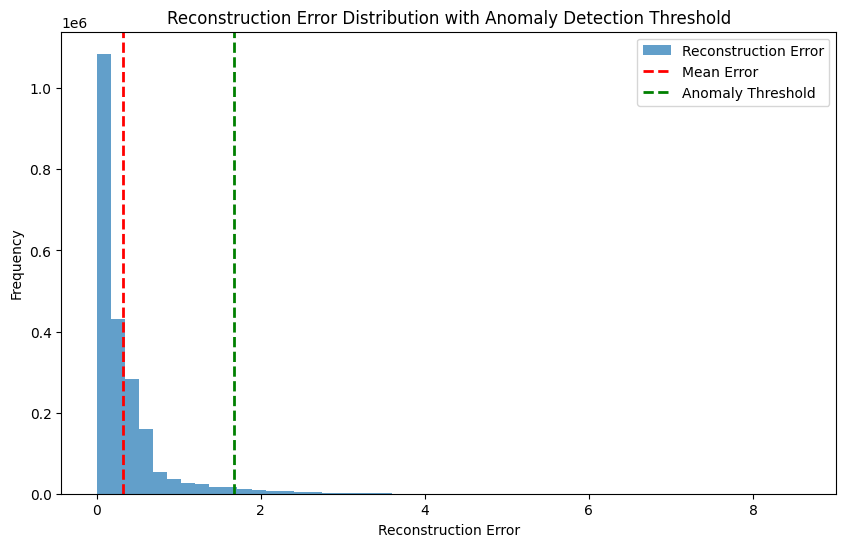

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.7, label='Reconstruction Error')
plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label='Mean Error')
plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label='Anomaly Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution with Anomaly Detection Threshold')
plt.legend()
plt.show()


In [ ]:
print(f"The threshold value for anomaly detection is: {threshold}")


The threshold value for anomaly detection is: 1.673935104462178


**Detection from the entire model (VAE-Transformer)**

In [ ]:

reconstructed_sequences = transformer_model.predict(sequences)
reconstruction_error_transformer = np.mean(np.square(sequences - reconstructed_sequences), axis=(1, 2))


68240/68240 ━━━━━━━━━━━━━━━━━━━━ 110s 2ms/step


In [ ]:
# Calculate mean and standard deviation of reconstruction error
mean_transformer_error = np.mean(reconstruction_error_transformer)
std_transformer_error = np.std(reconstruction_error_transformer)

# Define a threshold for anomaly detection (adjust the coefficient as needed)
transformer_threshold = mean_transformer_error + (0.3) * std_transformer_error

# Identify anomalies based on the threshold
transformer_anomaly_indices = np.where(reconstruction_error_transformer > transformer_threshold)[0]
transformer_anomaly_data = transactions[transactions['kmeans_label'] == 0].iloc[transformer_anomaly_indices].copy()  # Explicitly create a copy

# Analyze the detected anomalies
print("Anomalies detected by Transformer:")
print(transformer_anomaly_data[['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals']])

# Compare with Rule 15 anomalies
rule_15_anomalies_indices = set(rule_15_anomalies.index)
transformer_anomalies_indices = set(transformer_anomaly_data.index)
common_transformer_anomalies = rule_15_anomalies_indices.intersection(transformer_anomalies_indices)

print(f"Number of common anomalies between rule 15 and Transformer: {len(common_transformer_anomalies)}")

# Extract the common anomalies (transactions)
# Extract the common anomalies (transactions)
common_anomaly_data = transformer_anomaly_data.loc[list(common_transformer_anomalies)] # Convert set to list

print("\nCommon Anomalies Detected by Both Rule 15 and Transformer:")
print(common_anomaly_data[['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals']])

# Evaluate the performance of anomaly detection
cluster_0_true_labels_transformer = [1 if i in rule_15_anomalies.index else 0 for i in transactions[transactions['kmeans_label'] == 0].index]
cluster_0_predicted_labels_transformer = [1 if i in transformer_anomaly_data.index else 0 for i in transactions[transactions['kmeans_label'] == 0].index]

if len(cluster_0_true_labels_transformer) == len(cluster_0_predicted_labels_transformer):
    recall_transformer = recall_score(cluster_0_true_labels_transformer, cluster_0_predicted_labels_transformer)
    precision_transformer = precision_score(cluster_0_true_labels_transformer, cluster_0_predicted_labels_transformer)
    accuracy_transformer = accuracy_score(cluster_0_true_labels_transformer, cluster_0_predicted_labels_transformer)
    print("\nRecall (Transformer):", recall_transformer)
    print("Precision (Transformer):", precision_transformer)
    print("Accuracy (Transformer):", accuracy_transformer)
else:
    print("Error: True labels and predicted labels have different lengths (Transformer)")

Anomalies detected by Transformer:
                                               CUST_CUSTNO   DATE_ONLY  \
26       0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...  2023-08-09   
28       0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...  2023-08-11   
29       0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...  2023-08-12   
31       0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...  2023-08-15   
32       0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...  2023-08-16   
...                                                    ...         ...   
6128251  ffffaa126887038ed403e49535cebc14cc4f1c1a28e62c...  2023-08-28   
6128257  ffffaa126887038ed403e49535cebc14cc4f1c1a28e62c...  2023-09-03   
6128258  ffffaa126887038ed403e49535cebc14cc4f1c1a28e62c...  2023-09-04   
6128261  ffffaa126887038ed403e49535cebc14cc4f1c1a28e62c...  2023-09-07   
6128263  ffffe6ffe4982025013118d59589d6f01c57e766082750...  2023-08-04   

         total_deposits  total_withdrawals  
26               5000.0        

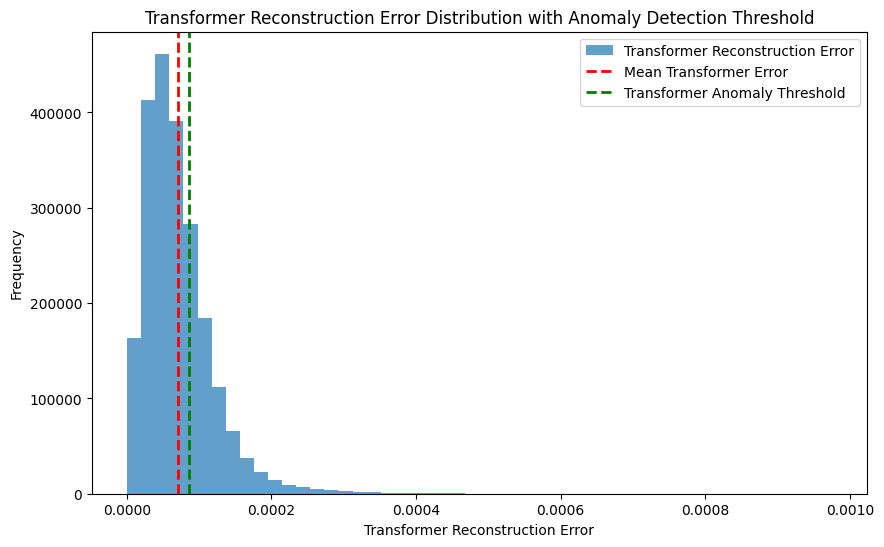

The threshold value for anomaly detection (Transformer) is: 8.542155555915087e-05


In [ ]:

# Visualize the reconstruction error distribution for the Transformer
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error_transformer, bins=50, alpha=0.7, label='Transformer Reconstruction Error')
plt.axvline(mean_transformer_error, color='red', linestyle='dashed', linewidth=2, label='Mean Transformer Error')
plt.axvline(transformer_threshold, color='green', linestyle='dashed', linewidth=2, label='Transformer Anomaly Threshold')
plt.xlabel('Transformer Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Transformer Reconstruction Error Distribution with Anomaly Detection Threshold')
plt.legend()
plt.show()

print(f"The threshold value for anomaly detection (Transformer) is: {transformer_threshold}")

